In [10]:
import os, sys, inspect

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
parentdir = os.path.dirname(parentdir)
sys.path.insert(0,parentdir)

In [15]:
currentdir

'C:\\Repos\\thesis_repo\\Testing\\Peter\\Archive'

In [2]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import matplotlib.mlab as mlab
#from Optimizers.Vprop import Vprop as Vprop
from Optimizers.noisyAdam import noisyAdam as noisyAdam
#from Optimizers.noisyKFAC3 import noisyKFAC as noisyKFAC
#from Optimizers.Newton import Newton as Newton
from Utilities.create_dataloaders import create_dataloaders 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from torch.utils.data import DataLoader

ModuleNotFoundError: No module named 'Utilities.create_dataloaders'

# Linear Regression Energy Landscape on 2 Parameters (w1*, w2*)

####  <span style="color:blue">NORMAL SETUP</span> 
####  $y = Xw + \epsilon$
#### Let **$X$** be an $n$x$k$ matrix with $n$ observations and $k$ features. 
#### Let $y$ be an $n$x$1$ vector 
#### Let $\epsilon$ be an $n$x$1$ vector
#### Let $w$ be an $k$x$1$ vector

### Experiment 2:
#### In this experiment we would like to test how the optimizers behave under the normal setup above. That is, when $w$ is fixed (one set of weights rather than several samples as in Exp1) and we have multiple data samples, $X$, rather than a single one (as in Exp1). In this framework the variability introduced to the model stems from the data. 

### Let's Start!
#### 1. Define the Weights

In [2]:
w_mu  = np.array([[0.2 , 0.1]], dtype=np.float32).transpose()                # <======== Define W mu
print('w_mu shape (kx1): ', w_mu.shape)
print('w_mu: ', w_mu)

w_mu shape (kx1):  (2, 1)
w_mu:  [[0.2]
 [0.1]]


#### 2. Define $X$ data samples

In [3]:
X_mu  = np.array( [2. , 3.] )                           # <======== Define X mu
X_S   = np.matrix(' 1 0 ; 0 1 ')                          # <======== Define X Sigma
n     = 100                                               # <======== Define number of data samples to be drawn


X = np.random.multivariate_normal( X_mu, X_S, n).astype(np.float32)
print('X shape (nxk):    ', X.shape)


X shape (nxk):     (100, 2)


#### 3. Define Noise $(\epsilon)$ Sigma

In [4]:
e_sigma = 0.1                          # <======== Define Noise Sigma
eps = np.random.normal(0, e_sigma, n).reshape(n,1).astype(dtype=np.float32)
print('Noise shape (nx1): ', eps.shape)

Noise shape (nx1):  (100, 1)


#### 4. Create $y$ (with some noise)

In [5]:
Y = np.add( np.matmul( X, w_mu), eps)
print('y shape (nx1): ', Y.shape)

y shape (nx1):  (100, 1)


#### 5. Define Linear Regression Network

In [6]:
class LinearRegressionModel(nn.Module):
    
    def __init__(self, in_dim, out_dim):
        super(LinearRegressionModel, self).__init__()
        self.Linear = nn.Linear(in_dim, out_dim, bias=False)
        
    def forward(self, x):
        return self.Linear(x)

#### 6. Define Initialization Point 

In [7]:
input_dim  = 2
output_dim = 1

SGD_model       = LinearRegressionModel(input_dim,output_dim)
LBFGS_model     = LinearRegressionModel(input_dim,output_dim)
#Newton_model    = LinearRegressionModel(input_dim,output_dim)
Vprop_model     = LinearRegressionModel(input_dim,output_dim)
noisyAdam_model = LinearRegressionModel(input_dim,output_dim)
noisyKFAC_model = LinearRegressionModel(input_dim,output_dim)


criterion = nn.MSELoss()# Mean Squared Loss


# W Initialization Point
i0 = torch.Tensor([-7.5 , -2.5])               # <========= Define Init Point
i0.resize_(1,2)
for p in list(SGD_model.parameters()):
    p.data = torch.Tensor(i0)
#for p in list(Newton_model.parameters()):
#    p.data = torch.Tensor(i0)
for p in list(LBFGS_model.parameters()):
    p.data = torch.Tensor(i0)
for p in list(Vprop_model.parameters()):
    p.data = torch.Tensor(i0)
for p in list(noisyAdam_model.parameters()):
    p.data = torch.Tensor(i0)
for p in list(noisyKFAC_model.parameters()):
    p.data = torch.Tensor(i0)


#### 7. Tune Optimizers

In [8]:
# Define hyperparameters
l_rate    = 1e-3
precision = 1
alpha     = 0.99999
N         = n
gamma_ex  = 1
t_inv     = 1
t_stats   = 1

# optimizers
SGD   = torch.optim.SGD(SGD_model.parameters(), lr=l_rate)

#NEWTON= Newton(Newton_model.parameters(), lr=l_rate*1000)

LBFGS = torch.optim.LBFGS(LBFGS_model.parameters(), lr=l_rate)

VPROP = Vprop(Vprop_model.parameters(), alpha=alpha, precision=precision, lr=l_rate)

nADAM = noisyAdam(noisyAdam_model.parameters(), num_examples=N, gamma_ex=gamma_ex, lr=l_rate)

nKFAC = noisyKFAC(params=noisyKFAC_model.parameters(), layers=noisyKFAC_model.modules(), num_examples=N, lr=l_rate, t_inv=t_inv, t_stats=t_stats)


#### 8. Energy Landscape Function

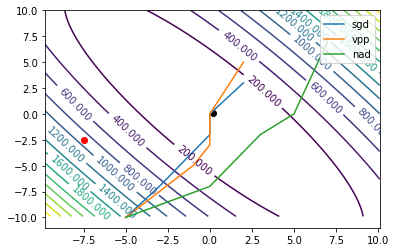

In [9]:

ws = 10                                      # <============= define window scale factor
W1 = np.arange(w_mu[0]-ws, w_mu[0]+ws, 0.1)
W2 = np.arange(w_mu[1]-ws, w_mu[1]+ws, 0.1)
W1, W2 = np.meshgrid(W1, W2)

#eps = np.random.normal(0, 5, 2*n).reshape(n,2)
Z = np.zeros(shape=(len(W1), len(W1)))
for i in range(len(W1)):
    for j in range(len(W1)):
        Xw = np.matmul(X, np.row_stack((W1[0,i], W2[j,0])).astype(np.float32))
        Z[i,j] = np.mean((Y.transpose() - Xw)**2)


        
plt.figure()
CS = plt.contour(W1, W2, Z, 15)
plt.clabel(CS, inline=1, fontsize=10)
plt.plot(w_mu[0], w_mu[1], 'ko')
plt.plot(i0[0][0], i0[0][1], 'ro')
plt.plot([-5,-3,0,0,2], [-10,-7,-2,0,3], label='sgd')
plt.plot([-5,-1,0,0,2], [-10,-5,-3,0,5], label='vpp')
plt.plot([-5,0,3,5,7], [-10,-7,-2,0,7], label='nad')
plt.legend(loc='upper right')
plt.show()





def plot_landscape_and_losses(vpp_dist, nad_dist, w_mu, wdict, losses, labels, num_models):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,10)) 
    fig.tight_layout()    
    clear_output(wait=True)
    
    # plot 1 Error Landscape
    plt.subplot(2,2,1)
    CS = plt.contour(W1, W2, Z, 15)
    plt.clabel(CS, inline=1, fontsize=10)
    plt.plot(w_mu[0], w_mu[1], 'ko')
    plt.plot(i0[0][0], i0[0][1], 'yo')
    plt.plot(wdict['sgd_w1'], wdict['sgd_w2'], label=labels[0])
    plt.plot(wdict['vpp_w1'], wdict['vpp_w2'], label=labels[1])
    plt.plot(wdict['nad_w1'], wdict['nad_w2'], label=labels[2])
    plt.plot(wdict['kfac_w1'], wdict['kfac_w2'], label=labels[3])
    #plt.plot(wdict['lbfgs_w1'], wdict['lbfgs_w2'], label=labels[4])
    #plt.plot(wdict['newton_w1'], wdict['newton_w2'], label=labels[4])
    plt.legend(loc='upper right')
    
    # plot 2 losses
    plt.subplot(2,2,2)
    for i in range(num_models):
        plt.plot(losses[i] , label=labels[i])
    plt.legend(loc='upper right')
    
    plt.show()
    

In [10]:
def closure():
            LBFGS.zero_grad()
            outputs_lb = LBFGS_model.forward(inputs)
            loss_lb = criterion(outputs_lb, targets)
            #print('loss:', loss_lb.data.numpy()[0])
            #print('epoch {}, LBFGS loss {}'.format(epoch, loss_lb.data[0]))
            loss_lb.backward()
            return loss_lb

#### 9. Train Models and Visualize Optimization

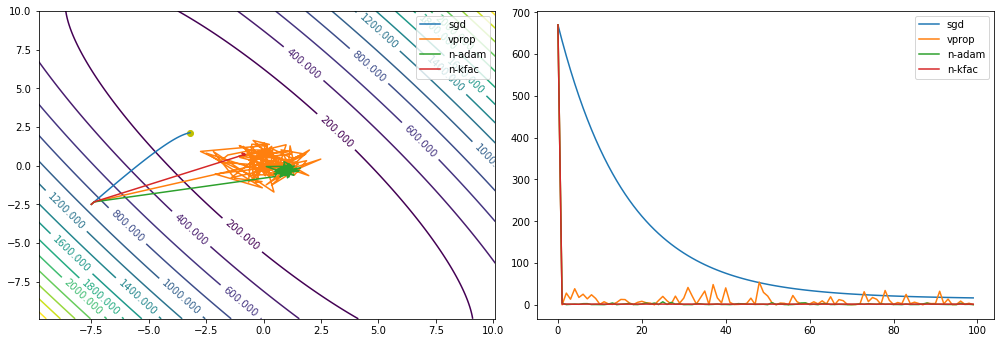

epoch 99, SGD loss   16.532201766967773
epoch 99, Vpp loss   0.5955856442451477
epoch 99, Nad loss   0.43682292103767395
epoch 99, NKfac loss 1.5360064506530762


In [11]:
epochs = 150
losses_sg = []
losses_vp = []
losses_na = []
losses_kfac = []
#losses_lb = []
losses_newton = []

p_w1      = np.zeros(shape=(epochs))
p_w2      = np.zeros(shape=(epochs))
wdict = {}
wdict['sgd_w1']  = [i0[0][0]]
wdict['sgd_w2']  = [i0[0][1]]
wdict['vpp_w1']  = [i0[0][0]]
wdict['vpp_w2']  = [i0[0][1]]
wdict['nad_w1']  = [i0[0][0]]
wdict['nad_w2']  = [i0[0][1]]
wdict['kfac_w1'] = [i0[0][0]]
wdict['kfac_w2'] = [i0[0][1]]
#wdict['lbfgs_w1'] = [i0[0][0]]
#wdict['lbfgs_w2'] = [i0[0][1]]
#wdict['newton_w1'] = [i0[0][0]]
#wdict['newton_w2'] = [i0[0][1]]

plt.figure()


for epoch in range(epochs):

    inputs  = Variable(torch.from_numpy(X))
    targets = Variable(torch.from_numpy(Y))
    
    # sample
    vpp_dist = VPROP.sample(init_point=i0)
    nad_dist = nADAM.sample(init_point=i0)
    nKFAC.sample(init_point=i0)

    # forward pass
    SGD.zero_grad()
    #NEWTON.zero_grad()
    #LBFGS.zero_grad()
    VPROP.zero_grad()
    nADAM.zero_grad()
    nKFAC.zero_grad()

    outputs_sg = SGD_model.forward(inputs)
    #outputs_nt = Newton_model.forward(inputs)
    #outputs_lb = LBFGS_model.forward(inputs)
    outputs_vp = Vprop_model.forward(inputs)
    outputs_na = noisyAdam_model.forward(inputs)
    outputs_kc = noisyKFAC_model.forward(inputs)


    # backprop & update
    loss_sg = criterion(outputs_sg, targets)
    #loss_nt = criterion(outputs_nt, targets)
    #loss_lb = criterion(outputs_lb, targets)
    loss_vp = criterion(outputs_vp, targets)
    loss_na = criterion(outputs_na, targets)
    loss_kf = criterion(outputs_kc, targets)

    loss_sg.backward()
    #loss_nt.backward(retain_graph=True)
    #loss_lb.backward()
    loss_vp.backward()
    loss_na.backward()
    loss_kf.backward()

    SGD.step()
    #NEWTON.step(loss_nt, Newton_model)
    #loss_lb = LBFGS.step(closure)
    VPROP.step()
    nADAM.step()
    nKFAC.step()

    # adapt lr
    #SGD_scheduler.step()

    """______ Plots _____"""
    sgd=[]; lbfgs=[]; vp=[]; na=[]
    for p in list(SGD_model.parameters()):
        wdict['sgd_w1'] += [p.data[0][0]]
        wdict['sgd_w2'] += [p.data[0][1]]
    #for p in list(Newton_model.parameters()):
    #    wdict['newton_w1'] += [p.data[0][0]]
    #    wdict['newton_w2'] += [p.data[0][1]]
    #for p in list(LBFGS_model.parameters()):
    #    wdict['lbfgs_w1'] += [p.data[0][0]]
    #    wdict['lbfgs_w2'] += [p.data[0][1]]
    for p in list(Vprop_model.parameters()):
        wdict['vpp_w1'] += [p.data[0][0]]
        wdict['vpp_w2'] += [p.data[0][1]]
    for p in list(noisyAdam_model.parameters()):
        wdict['nad_w1'] += [p.data[0][0]]
        wdict['nad_w2'] += [p.data[0][1]] 
    for p in list(noisyKFAC_model.parameters()):
        wdict['kfac_w1'] += [p.data[0][0]]
        wdict['kfac_w2'] += [p.data[0][1]]


    # collect losses
    losses_sg.append(loss_sg.data[0])
    #losses_newton.append(loss_nt.data[0])
    #losses_lb.append(loss_lb.data[0])
    losses_vp.append(loss_vp.data[0])
    losses_na.append(loss_na.data[0])
    losses_kfac.append(loss_kf.data[0])
    
    
    plot_landscape_and_losses(vpp_dist, nad_dist, w_mu, wdict,  \
                              losses=[losses_sg, losses_vp, losses_na, losses_kfac, losses_newton], \
                              labels=['sgd', 'vprop', 'n-adam', 'n-kfac',  'newton'], \
                              num_models=4)
    
    print('epoch {}, SGD loss   {}'.format(epoch, loss_sg.data[0]))
    #print('epoch {}, Newton loss{}'.format(epoch, loss_nt.data[0]))
    #print('epoch {}, LBFGS loss {}'.format(epoch, loss_lb.data[0]))
    print('epoch {}, Vpp loss   {}'.format(epoch, loss_vp.data[0]))
    print('epoch {}, Nad loss   {}'.format(epoch, loss_na.data[0]))
    print('epoch {}, NKfac loss {}'.format(epoch, loss_kf.data[0]))
